In [1]:
import matplotlib as mpl
import gc
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u 

from snewpy.neutrino import Flavor, MassHierarchy, MixingParameters
from snewpy.models.ccsn import Nakazato_2013
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes

mpl.rc('font', size=18)
%matplotlib inline

In [2]:
model = Nakazato_2013(progenitor_mass=20*u.solMass, revival_time=100*u.ms, metallicity=0.004, eos='shen')
model

**Nakazato_2013 Model**: nakazato-shen-z0.004-t_rev100ms-s20.0.fits

|Parameter|Value|
|:--------|:----:|
|Progenitor mass | $20$ $\mathrm{M_{\odot}}$|
|Revival time | $100$ $\mathrm{ms}$|
|Metallicity | 0.004 |
|EOS | shen |

In [3]:
        t= [10,50] * u.ms
        D=10*u.kpc
        M=0.5* u.eV
        E = np.linspace(1,50,10) * u.MeV 
        delayed_spectrum = {}
        for flavor in Flavor:
            delayed_spectrum[flavor]=np.zeros((len(t), len(E)))<<1 / (u.erg * u.s)

        for i,e in enumerate(E):
            tof=model.get_tof(D, e,M)
            T=t-tof
            initialspectra=model.get_initial_spectra(T, e)
            delayed_spectrum[Flavor.NU_E][:,i]= initialspectra[Flavor.NU_E]
            delayed_spectrum[Flavor.NU_X][:, i] = initialspectra[Flavor.NU_E]
            delayed_spectrum[Flavor.NU_E_BAR][:, i] = initialspectra[Flavor.NU_E]
            delayed_spectrum[Flavor.NU_X_BAR][:, i] = initialspectra[Flavor.NU_E]
            
        initial=model.get_initial_spectra(T, E)
        print(delayed_spectrum[0][1])
        print(initial[0][1])

[1.99169810e+60 2.63847573e+62 1.96301235e+62 1.08610704e+62
 5.21881664e+61 2.30888569e+61 9.67507687e+60 3.90150630e+60
 1.52897548e+60 5.86106085e+59] 1 / (erg s)
[4.43209033e+61 2.32701835e+62 1.87769409e+62 1.06513732e+62
 5.17180087e+61 2.29944703e+61 9.65925061e+60 3.89970238e+60
 1.52895651e+60 5.86106085e+59] 1 / (erg s)


In [4]:
D=10*u.kpc
c = 299792458 * u.m / u.s
tof_light=D.to(u.m)/c

T=(100* u.ms)
    
E = 1* u.MeV
d = (10*u.kpc).to('cm').value # distance to SN
    
#M=np.linspace(0.1,1,5)*u.eV
M=0.5* u.eV
   
V= D.to(u.m).value/(c.value*(1-(M.value/ E.to(u.eV).value)**2)**0.5)-D.to(u.m).value/c.value
print(V)
for flavor in Flavor:
    if flavor==0:
        print(flavor)

0.128662109375
0


In [5]:
gc.collect()
def plot_spectra12(model, xform_nmo, xform_imo, t):
    """Plot initial and oscillated neutrino luminosities.
    
    Parameters
    ----------
    model : SupernovaModel
        An input model from a CCSN simulation.
    flav_xform : FlavorTransformation
        A FlavorTransformation subclass; used to create an instance.
    t : astropy.Quantity
        Time to compute the spectrum.
    """
    energie = np.linspace(1,51,101) * u.MeV 
    energies = np.linspace(1,51,1001) * u.MeV   
    D=10* u.kpc
    d = (10*u.kpc).to('cm').value # distance to SN
    mass=1*u.eV   
    m=0.5 *u.eV 
    
    

    #get the spectra
    ospec_nmo = model.get_transformed_spectra(t, energies, xform_nmo)
    #ospec_imo = model.get_transformed_spectra(t, energies, xform_imo)
    ospec_nmo_tof= model.get_tof_transformed_spectra( t, energies,  xform_nmo)
    ospec_imo_tof= model.get_tof_transformed_spectra1( t, energies,  xform_nmo)


    for flavor in Flavor:
        for j, E in enumerate(energies):
            ospec_nmo[flavor][j] /= (4.*np.pi*d**2)
            #ospec_imo[flavor][j] /= (4.*np.pi*d**2)
            ospec_nmo_tof[flavor][0][j] /= (4.*np.pi*d**2)
            ospec_imo_tof[flavor][0][j] /= (4.*np.pi*d**2)
    gc.collect()  # 强制垃圾回收
    
    energy_bins = [(1, 11), (11, 30), (31, 51)]
    fig, axes = plt.subplots(2,3, figsize=(24,21), tight_layout=True)
    titles = [f'nmo_tof (t = {t}) (m = {mass})(energy steps: 0.05MeV)', f'nmo_tof (t = {t}) (m = {m})(energy steps: 0.05MeV)']
    smax = [0.,0.,0.]
    for i, (spec_olum, spec_ospec) in enumerate([(ospec_nmo, ospec_nmo_tof), (ospec_nmo, ospec_imo_tof)]):
         for j, (energy_min, energy_max) in enumerate(energy_bins):
            ax = axes[i,j]
            
            mask = (energies >= energy_min* u.MeV) & (energies <energy_max*u.MeV)
            
            
            for flavor in Flavor:
                if i == 0:
                    smax[j] = np.maximum(smax[j], 1.1 * np.max(spec_olum[flavor][mask]).value)
                # 在子图上绘制光度曲线
                ax.plot(energies[mask].value,  # 使用筛选后的能量数据
                    spec_olum[flavor][mask].value,  # 光度数据
                    label=flavor.to_tex(),  # 图例标签
                    lw=3,  # 线宽
                    ls='--',
                    color='C0' if flavor==0 else 'C1' if flavor==1 else 'C2' if flavor==2 else 'C3')  # 线型
                ax.plot(energies[mask].value,  # 使用筛选后的能量数据
                    spec_ospec[flavor][0][mask].value,  # 光度数据，使用无单位的值
                    label=f'TOF {flavor.to_tex()}',  # 图例标签
                    lw=3,  # 线宽
                    ls='-',
                    color='C0' if flavor==0 else 'C1' if flavor==1 else 'C2' if flavor==2 else 'C3')  # 线型
             # 设置子图的x轴和y轴范围
            ax.set(xlim=(energy_min, energy_max), ylim=(0, smax[j]))
            
            # 如果是第一个能量范围，设置y轴标签和图例
            if j == 0:
                ax.set(ylabel=r'flux [erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
                ax.legend(loc='upper right', ncol=1, fontsize=18)
            
            # 如果是第二列，设置子图标题
            if j == 1:
                ax.set(title=titles[i])
            
            # 如果不是最后一行，隐藏x轴标签
            if i < 1:
                ax.set(xticklabels=[])
            else:
                # 否则，设置x轴标签
                ax.set(xlabel='Energy [MeV]')
            
            # 设置网格线
            ax.grid(ls=':')
                
    return fig

'fig,tof1,ospec_nmo_tof= plot_spectra12(model, AdiabaticMSW(), AdiabaticMSW(mh=MassHierarchy.INVERTED), 100*u.ms)\nprint(tof1)\nprint(ospec_nmo_tof[2])\nprint(np.max(ospec_nmo_tof[2]))\nprint(np.argmax(ospec_nmo_tof[2]))'

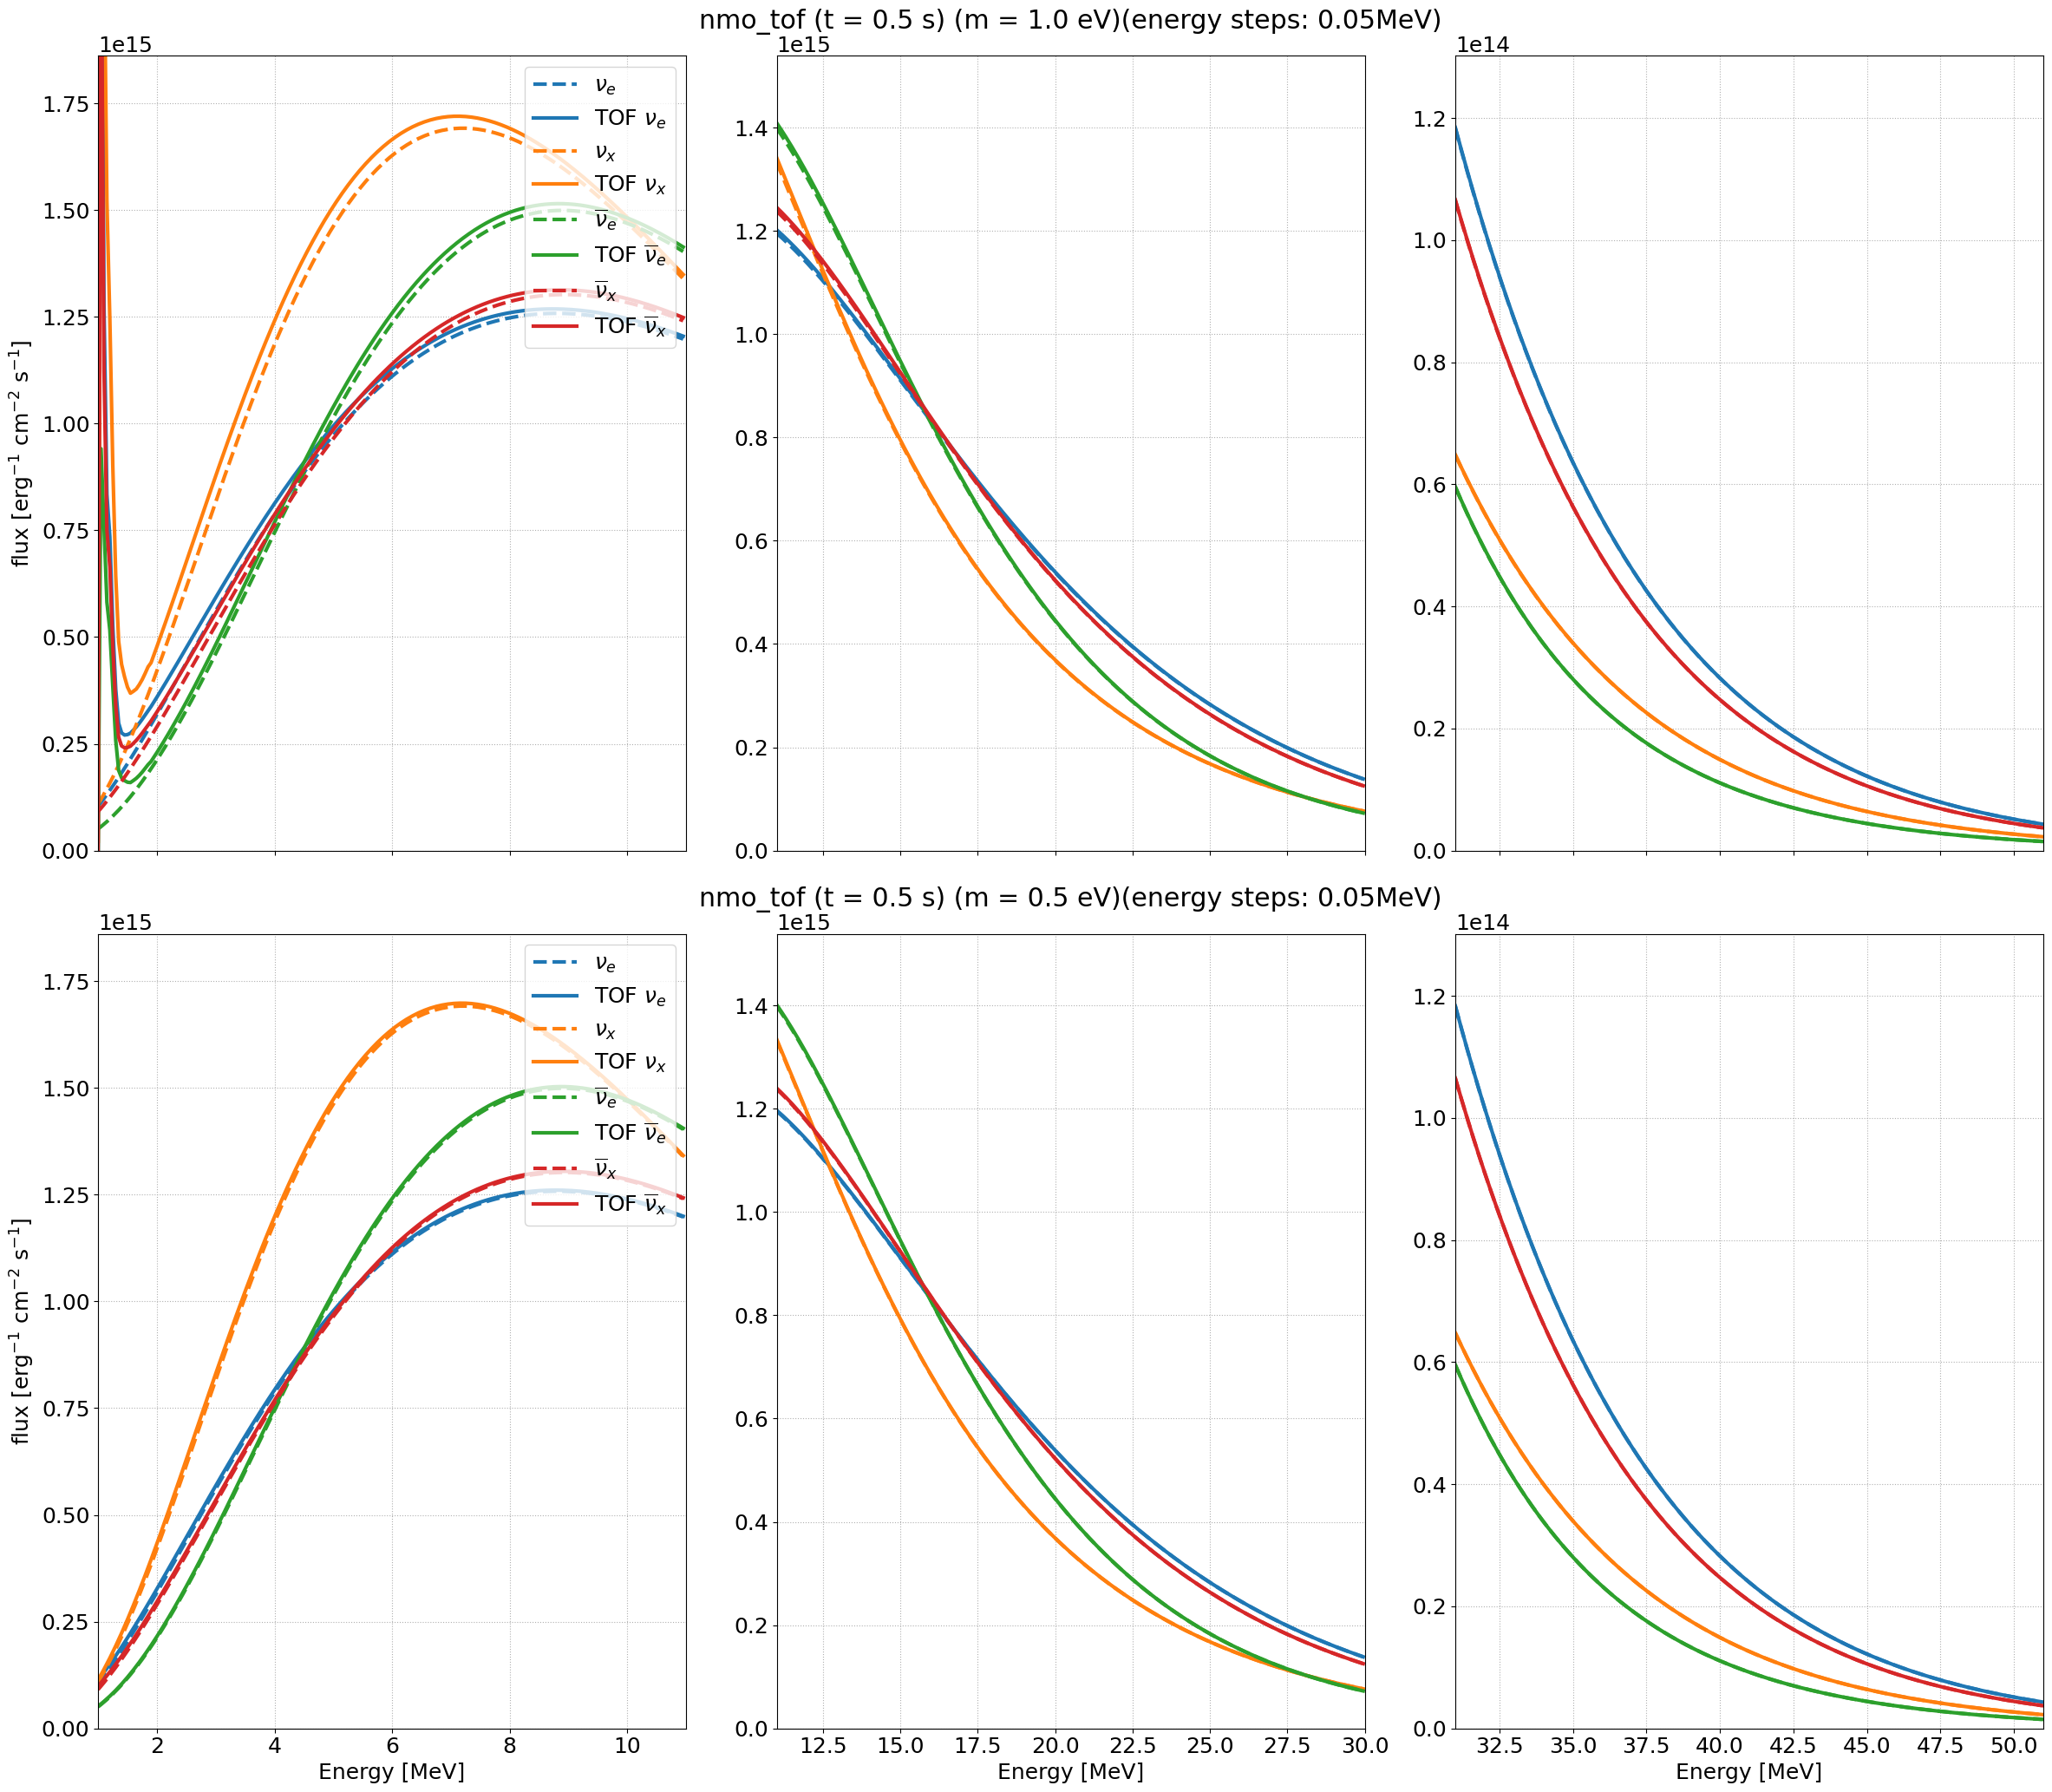

In [6]:
gc.collect()
fig= plot_spectra12(model, AdiabaticMSW(), AdiabaticMSW(mh=MassHierarchy.INVERTED), 0.5*u.s)
"""fig,tof1,ospec_nmo_tof= plot_spectra12(model, AdiabaticMSW(), AdiabaticMSW(mh=MassHierarchy.INVERTED), 100*u.ms)
print(tof1)
print(ospec_nmo_tof[2])
print(np.max(ospec_nmo_tof[2]))
print(np.argmax(ospec_nmo_tof[2]))"""

In [ ]:
gc.collect()
energies = np.linspace(1,50,1000) * u.MeV   
D=10* u.kpc
d = (10*u.kpc).to('cm').value # distance to SN
mass=0.5 *u.eV    
t=100*u.ms
"""   #get the spectra
ospec_nmo = model.get_transformed_spectra(t, energies, AdiabaticMSW())
ospec_nmo_tof,tof1= model.get_delayed_flux(D, t, energies, mass, AdiabaticMSW())
ospec_imo_tof,tof2= model.get_delayed_flux(D, t, energies, mass, AdiabaticMSW(mh=MassHierarchy.INVERTED))
    
for flavor in Flavor:
    for j, E in enumerate(energies):
        ospec_nmo[flavor][j] /= (4.*np.pi*d**2)
        ospec_nmo_tof[flavor][j] /= (4.*np.pi*d**2)
        ospec_imo_tof[flavor][j] /= (4.*np.pi*d**2)
gc.collect()  # 强制垃圾回收
print(tof1)
for i,e in enumerate(energies):
    print(i,e)
mask = (energies >= 1* u.MeV) & (energies <=10*u.MeV)
print(ospec_nmo_tof[0][mask]/1e15)"""
times=model.get_time()
burst_epoch = []
accretion_epoch = []
cooling_epoch = []
for i, t in enumerate(times):
    if t <= 0.2 * u.s:
        burst_epoch.append(t.to('ms').value)
    elif 0.2 * u.s < t <= 0.5 * u.s:
        accretion_epoch.append(t)
    elif t > 10 * u.s:
        cooling_epoch.append(t)

E=30*u.MeV
Y=24*u.MeV
Z=35*u.MeV
energies = np.linspace(1,51,101) * u.MeV 
x=model.get_transformed_spectra(burst_epoch*u.ms, E, AdiabaticMSW())
y=model.get_transformed_spectra(burst_epoch*u.ms, Y, AdiabaticMSW())
z=model.get_transformed_spectra(burst_epoch*u.ms, Z, AdiabaticMSW())
K=model.get_initial_spectra(burst_epoch*u.ms, E=30*u.MeV)
K1=model.get_initial_spectra(burst_epoch*u.ms, E=30*u.MeV)
print(type(K[0].value),K[0].value.shape)

#print(K[0],K1[0])
"""
for i,t in enumerate(burst_epoch*u.ms):
    print(i,t)
    print(x[0][i])
print(burst_epoch)

plt.plot(burst_epoch, x[0],label='x0')
plt.plot(burst_epoch, y[0],label='x1')
plt.plot(burst_epoch, z[0],label='x2')
plt.legend()
"""


"""for i,e in enumerate(energies):
    print(i,e)
    print(ospec_nmo_tof[0][i]/1e15)"""
#print(ospec_imo_tof[0])
"13: <Quantity 52.17865887 ms>,e=1.65 nmo 0.5ev 100ms"
"13: <Quantity 52.17865887 ms>,e=1.3 imo 0.5ev 100ms" 
"46: <Quantity 51.61840129 ms>,e=3.3 nmo 1 ev 100ms"
"44: <Quantity 48.48632812 ms>,e=3.2 imo 1 ev 100ms"
"9: <Quantity 52.44140625 ms>,e=1.45 nmo 1 ev 300ms"
"9: <Quantity 52.44140625 ms>,e=1.45 imo 1 ev 300ms"
"1.10786758 1.10789201 1.11514915 1.12782054 1.14433436 1.16373347"
"1.18531469 1.20858909 1.23316752 1.25872388 1.2849947  1.31168222"

In [ ]:
def plot_flux(model, xform_nmo, xform_imo):
    """Plot initial and oscillated neutrino luminosities.
    
    Parameters
    ----------
    model : SupernovaModel
        An input model from a CCSN simulation.
    flav_xform : FlavorTransformation
        A FlavorTransformation subclass; used to create an instance.
    """
    
    energies = np.linspace(3,5,5) * u.MeV   
    D=10* u.kpc
    d = (10*u.kpc).to('cm').value # distance to SN
    mass=0.2* u.eV    
    times = model.get_time()
    burst_epoch = times <= 0.1*u.s
    accretion_epoch = (times > 0.1*u.s) & (times <= 0.5*u.s)
    cooling_epoch = (times > 0.5*u.s) & (times <= 10*u.s)
    
    
    ilum = {}
    olum_nmo = {}
    olum_imo = {}
    olum_nmo_tof={}
    olum_imo_tof={}
    
    for flavor in Flavor:
        ilum[flavor] = {}
        olum_nmo[flavor] = {}
        olum_imo[flavor]= {}
        olum_nmo_tof[flavor] = {}
        olum_imo_tof[flavor] = {}
        for i, t in enumerate(times):
            ilum[flavor][t] = np.zeros(len(energies))
            olum_nmo[flavor][t] = np.zeros(len(energies))
            olum_imo[flavor][t]= np.zeros(len(energies))
            olum_nmo_tof[flavor][t] = np.zeros(len(energies))
            olum_imo_tof[flavor][t] = np.zeros(len(energies))

    # Compute the transformed and untransformed flux at each time.
    for i, E in enumerate(energies):
        ispec = model.get_initial_spectra(times, energies)
        ospec_nmo = model.get_transformed_spectra(times, energies, xform_nmo)
        ospec_imo = model.get_transformed_spectra(times, energies, xform_imo)
        #ospec_imo_tof = model.get_delayed_flux(D, t, energies, mass, xform_imo)
        for flavor in Flavor:
            for j, t in enumerate(times):
                ispec[flavor][j] /= (4.*np.pi*d**2)
                ospec_nmo[flavor][j] /= (4.*np.pi*d**2)
                ospec_imo[flavor][j] /= (4.*np.pi*d**2)
                
            ilum[flavor][t] = ispec[flavor][j].value
            olum_nmo[flavor][t] = ospec_nmo[flavor][j].value
            olum_imo[flavor][t] = ospec_imo[flavor][j].value
                #ospec_imo_tof[flavor][j] /= (4.*np.pi*d**2)
        
    
            #olum_imo_tof[flavor][i] = np.trapz(ospec_imo_tof[flavor].to('1/(erg*s)'), energies.to('erg')).value
            
    # make the figures 
    fig, axes = plt.subplots(1, 3, figsize=(20, 12), tight_layout=True)
    smax = [0., 0., 0.]

    # 颜色选择
    color_options = ['b', 'g', 'r', 'c', 'm', 'k']

    for j, phase in enumerate([burst_epoch, accretion_epoch, cooling_epoch]):
        ax = axes[j]
        timeunits = 'ms' if j == 0 else 's'
        for k, E in enumerate(energies):
            # 使用预定义的颜色，如果超出范围则重复使用颜色
            color = color_options[k % len(color_options)]
            phase_times = times[phase]
            phase_flux = np.array([olum_nmo[flavor][t][k] for t in phase_times])
            
            smax[j] = np.maximum(smax[j], 1.1 * np.max(olum_nmo[0][phase][k]))
            time_values = times[phase].to(timeunits)
            
            ax.plot(time_values, phase_flux, color=color, label=f'Energy {E:.2f} MeV', lw=3)
        ax.set(xlim=(time_values[0].value, time_values[-1].value), ylim=(0, smax[j]))

        if j == 0:    
            ax.set(ylabel=r'flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys(), loc='upper right', ncol=1, fontsize=18)

        ax.set_xlabel(f'Time [{timeunits}]')
        ax.grid(ls=':')
        ax.set_title(f'Epoch {j + 1}')

    return fig
    """
    fig, axes = plt.subplots(1,3, figsize=(20,12),tight_layout=True)
    smax = [0.,0.,0.]
    for j, phase in enumerate([burst_epoch, accretion_epoch, cooling_epoch]):
        ax = axes[j]
        timeunits = 'ms' if j==0 else 's'
        for k, E in enumerate(energies):
            colors = 'b' if k == 0 else ('g' if k == 1 else ('r' if k == 2 else ('c' if k == 3 else ('m' if k == 4 else 'k'))))
            smax[j] = np.maximum(smax[j], 1.1*np.max(olum_nmo[0][k][phase]))
            time_values = times[phase].to(timeunits)            
            ax.plot(time_values, olum_nmo[0][k][phase], color=colors, label=f'Energy {E:.2f} MeV', lw=3)
            
                
        ax.set(xlim=(times[phase][0].to(timeunits).value, times[phase][-1].to(timeunits).value),
                       ylim=(0, smax[j]))
        if j==0:    
            ax.set(ylabel=r'flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys(), loc='upper right', ncol=1, fontsize=18)

        ax.set_xlabel(f'Time [{timeunits}]')
        ax.grid(ls=':')
        
        ax.set_title(f'Epoch {j+1}')

    return fig"""

In [ ]:
fig = plot_flux(model, AdiabaticMSW(), AdiabaticMSW(mh=MassHierarchy.INVERTED) )

In [ ]:
def plot_flux1(model, xform_nmo, xform_imo):
    """Plot initial and oscillated neutrino luminosities.
    
    Parameters
    ----------
    model : SupernovaModel
        An input model from a CCSN simulation.
    flav_xform : FlavorTransformation
        A FlavorTransformation subclass; used to create an instance.
    """
    
    energies = np.linspace(1,1.5,5) * u.MeV   
    D=10* u.kpc
    d = (10*u.kpc).to('cm').value # distance to SN
    mass=0.2* u.eV    
    times = model.get_time()
    burst_epoch = times <= 0.1*u.s
    accretion_epoch = (times > 0.1*u.s) & (times <= 0.5*u.s)
    cooling_epoch = (times > 0.5*u.s) & (times <= 10*u.s)
    
    ilum = {}
    olum_nmo = {}
    olum_imo = {}
    olum_nmo_tof={}
    olum_imo_tof={}
    
    for flavor in Flavor:
        ilum[flavor] = {}
        olum_nmo[flavor] = {}
        olum_imo[flavor]= {}
        olum_nmo_tof[flavor] = {}
        olum_imo_tof[flavor] = {}
        for i, E in enumerate(energies):
            ilum[flavor][i] = np.zeros(len(times))
            olum_nmo[flavor][i] = np.zeros(len(times))
            olum_imo[flavor][i]= np.zeros(len(times))
            olum_nmo_tof[flavor][i] = np.zeros(len(times))
            olum_imo_tof[flavor][i] = np.zeros(len(times))

    # Compute the transformed and untransformed flux at each time.
    for i, E in enumerate(energies):
        ispec = model.get_initial_spectra(times, energies)
        ospec_nmo = model.get_transformed_spectra(times, energies, xform_nmo)
        ospec_imo = model.get_transformed_spectra(times, energies, xform_imo)
        #ospec_imo_tof = model.get_delayed_flux(D, t, energies, mass, xform_imo)
        for flavor in Flavor:
            for j, e in enumerate(times):
                ispec[flavor][j] /= (4.*np.pi*d**2)
                ospec_nmo[flavor][j] /= (4.*np.pi*d**2)
                ospec_imo[flavor][j] /= (4.*np.pi*d**2)
        
        for flavor in Flavor:
            ilum[flavor][i] = ispec[flavor].value
            olum_nmo[flavor][i] =ospec_nmo[flavor].value
            olum_imo[flavor][i] =ospec_imo[flavor].value
                #ospec_imo_tof[flavor][j] /= (4.*np.pi*d**2)
        
    
            #olum_imo_tof[flavor][i] = np.trapz(ospec_imo_tof[flavor].to('1/(erg*s)'), energies.to('erg')).value
            
    # make the figures 
    fig, axes = plt.subplots(1,3, figsize=(20,21), tight_layout=True)
    titles = ['nmo_tof','imo_tof']
    
    smax = [0.,0.,0.]
    for i, spec in enumerate([ilum, olum_nmo, olum_imo]):
        for j, E in enumerate(energies):
            for k, phase in enumerate([burst_epoch, accretion_epoch, cooling_epoch]):
                ax = axes[i]
                timeunits = 'ms' if j==0 else 's'
                        
                smax[j] = np.maximum(smax[j], 1.1*np.max(olum_nmo[Flavor.NU_E][k][phase]))
                            
                ax.plot(times[phase].to(timeunits),
                            olum_nmo[Flavor.NU_E][k][phase], lw=3,
                            color='C0')
                    
                ax.set(xlim=(times[phase][0].to(timeunits).value, times[phase][-1].to(timeunits).value),
                           ylim=(0, smax[j]))
                    
                if j==0:
                    ax.set(ylabel=r'flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
                    ax.legend(loc='upper right', ncol=1, fontsize=18)
                ax.grid(ls=':')

      
    return fig


In [ ]:
fig = plot_flux1(model, AdiabaticMSW(), AdiabaticMSW(mh=MassHierarchy.INVERTED) )